In [1]:
import os
from ctypes import *

import numpy as np
import time
from PIL import Image
from sklearn.metrics import accuracy_score, mean_squared_error, accuracy_score
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
path_to_dll = "C:/Users/gautier/CLionProjects/MLP_Rattrapage/cmake-build-debug/libMLP3.dll"
mylib = cdll.LoadLibrary(path_to_dll)

In [3]:
X_train = []
Y_train = []
X_test = []
Y_test = []

def import_images_and_assign_labels(folder, label, type):
    showed = False
    for file in os.listdir(folder):
        image_path = folder + file
        im = Image.open(image_path)
        im = im.resize((32,32))
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (32 * 32 * 3))
        if (type == "train"):
            X_train.append(im_arr)
            Y_train.append(label)
        else:
            X_test.append(im_arr)
            Y_test.append(label)

def import_dataset():
    dataset_folder = "C:/Users/gautier/CLionProjects/MLP_Rattrapage/Datasets"
    train_folder = dataset_folder + "/train"
    test_folder = dataset_folder + "/test"
    import_images_and_assign_labels(train_folder + "/basque_flag/", [1, -1, -1], "train")
    import_images_and_assign_labels(train_folder + "/belgium_flag/", [-1, 1, -1], "train")
    import_images_and_assign_labels(train_folder + "/french_flag/", [-1, -1, 1], "train")
    import_images_and_assign_labels(test_folder + "/basque_flag/", [1, -1, -1], "test")
    import_images_and_assign_labels(test_folder + "/belgium_flag/", [-1, 1, -1], "test")
    import_images_and_assign_labels(test_folder + "/french_flag/", [-1, -1, 1], "test")
    return (np.array(X_train) / 255.0, np.array(Y_train)), (np.array(X_test) / 255.0, np.array(Y_test))


In [4]:
def mean_squared_error(Y_true, Y_pred):
    return np.sum((Y_true - Y_pred) ** 2) / len(Y_true)

In [5]:
def run_train():
    (X_train, Y_train), (X_test, Y_test) = import_dataset()
    dataset_inputs = np.array(X_train)
    dataset_expected_outputs = np.array(Y_train)
    #init_tab = [2, 3]
    #init_tab = [2, 8, 3]
    #init_tab = [2, 32, 3]
    init_tab = [2, 32, 32, 3]
    init_size = len(init_tab)
    init_type = c_int * init_size
    init = init_type(*init_tab)
    mylib.create_mlp_model.argtypes = [init_type, c_int]
    mylib.create_mlp_model.restype = c_void_p
    model = mylib.create_mlp_model(init, int(init_size))
    img_test = X_test
    mylib.getXSize.argtypes = [c_void_p]
    mylib.getXSize.restype = c_int
    tmp_len = mylib.getXSize(model)

    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])    
    flattened_dataset_outputs = []
    for p in dataset_expected_outputs:
        flattened_dataset_outputs.append(p[0])
        flattened_dataset_outputs.append(p[1])
        flattened_dataset_outputs.append(p[2])

    arrsize_flat = len(flattened_dataset_inputs)
    arrtype_flat = c_float * arrsize_flat
    arr_flat = arrtype_flat(*flattened_dataset_inputs)
    arrsize_exp = len(flattened_dataset_outputs)
    arrtype_exp = c_float * arrsize_exp
    arr_exp = arrtype_exp(*flattened_dataset_outputs)
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.argtypes = [c_void_p, arrtype_flat, c_int,
                                                                                         arrtype_exp, c_float, c_int]
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.restype = None
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model(model, arr_flat, arrsize_flat, arr_exp,
                                                                             0.0001, 10000)
    #####################
    
    arrsizeP = len(p)
    arrtypeP = c_float * arrsizeP
    arrP = arrtypeP(*p)
    mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
    mylib.predict_mlp_model_classification.restype = POINTER(c_float)
    
    losses = []
    val_losses = []
    accs = []
    val_accs = []
        
    for epoch in range(100):
        mylib.train_classification_stochastic_gradient_backpropagation_mlp_model(model, arr_flat, arrsize_flat, arr_exp,
                                                                             0.0001, 10000)
        Y_pred = []
        for p in Y_train :
            arrsizeP = len(p)
            arrtypeP = c_float * arrsizeP
            arrP = arrtypeP(*p)
            mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
            mylib.predict_mlp_model_classification.restype = POINTER(c_float)
            tmp = mylib.predict_mlp_model_classification(model, arrP)
            np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
            Y_pred.append(np_arr)
        loss = mean_squared_error(Y_train, Y_pred)
        losses.append(loss)

        """val_loss = mean_squared_error(Y_test, val_Y_pred)
        val_losses.append(val_loss)"""

        """acc = accuracy_score(np.argmax(Y_train, axis=1), np.argmax(Y_pred, axis=1))
        accs.append(acc)

        val_acc = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(val_Y_pred, axis=1))
        val_accs.append(val_acc)"""

        clear_output(True)

        plt.plot(losses)
        plt.plot(val_losses)
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.title('Evolution of loss (MSE)')
        plt.xlabel('epochs')
        plt.ylabel(f'mean squared error')
        plt.show()  

        plt.plot(accs)
        plt.plot(val_accs)
        plt.legend(['acc', 'val_acc'], loc='upper left')
        plt.title('Evolution of accuracy')
        plt.xlabel('epochs')
        plt.ylabel(f'accuracy')
        plt.show()

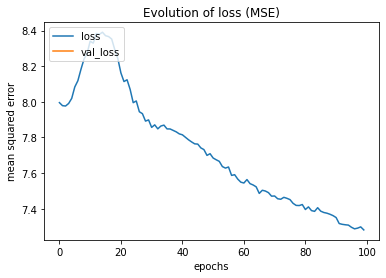

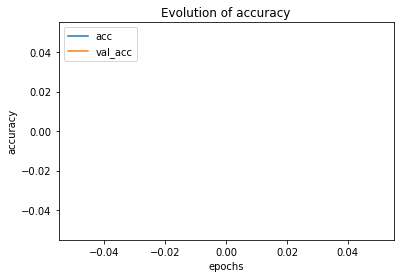

In [6]:
if __name__ == "__main__":
    run_train()